## Week 08 - Deep Learning

by Jorge Abrego

### Getting the Dataset

In this homework, we'll build a model for predicting if we have an image of a bee or a wasp. 
For this, we will use the "Bee or Wasp?" dataset that was obtained from [Kaggle](https://www.kaggle.com/datasets/jerzydziewierz/bee-vs-wasp) and slightly rebuilt. 

You can download the dataset for this homework from [here](https://github.com/SVizor42/ML_Zoomcamp/releases/download/bee-wasp-data/data.zip):

```bash
wget https://github.com/SVizor42/ML_Zoomcamp/releases/download/bee-wasp-data/data.zip
unzip data.zip
```

In the lectures we saw how to use a pre-trained neural network. In the homework, we'll train a much smaller model from scratch. 

> **Note:** you will need an environment with a GPU for this homework. We recommend to use [Saturn Cloud](https://bit.ly/saturn-mlzoomcamp). 
> You can also use a computer without a GPU (e.g. your laptop), but it will be slower.
> This homework was made in AWS Sagemaker Studio Lab, more information [here](https://studiolab.sagemaker.aws/)

### Loading libraries

In [1]:
import os
import shutil

import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

2023-11-19 22:35:50.148110: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-19 22:35:50.148152: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-19 22:35:50.148176: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Tensorflow inspection

In [2]:
import tensorflow
tensorflow.__version__

'2.14.1'

### Data Preparation

The dataset contains around 2500 images of bees and around 2100 images of wasps. 

The dataset contains separate folders for training and test sets. 

In [3]:
train_dir = './data/train'
test_dir = './data/test'

### Model

For this homework we will use Convolutional Neural Network (CNN). Like in the lectures, we'll use Keras.

You need to develop the model with following structure:

* The shape for input should be `(150, 150, 3)`
* Next, create a convolutional layer ([`Conv2D`](https://keras.io/api/layers/convolution_layers/convolution2d/)):
    * Use 32 filters
    * Kernel size should be `(3, 3)` (that's the size of the filter)
    * Use `'relu'` as activation 
* Reduce the size of the feature map with max pooling ([`MaxPooling2D`](https://keras.io/api/layers/pooling_layers/max_pooling2d/))
    * Set the pooling size to `(2, 2)`
* Turn the multi-dimensional result into vectors using a [`Flatten`](https://keras.io/api/layers/reshaping_layers/flatten/) layer
* Next, add a `Dense` layer with 64 neurons and `'relu'` activation
* Finally, create the `Dense` layer with 1 neuron - this will be the output
    * The output layer should have an activation - use the appropriate activation for the binary classification case

As optimizer use [`SGD`](https://keras.io/api/optimizers/sgd/) with the following parameters:

* `SGD(lr=0.002, momentum=0.8)`

In [4]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

### Question 1

Since we have a binary classification problem, what is the best loss function for us?

* `mean squared error`
* `binary crossentropy`
* `categorical crossentropy`
* `cosine similarity`

> **Note:** since we specify an activation for the output layer, we don't need to set `from_logits=True`

**Answer**: Binary cross-entropy is a handy loss function used in binary classification tasks to measure how well the predicted probabilities align with the true binary labels

In [5]:
model.compile(loss='binary_crossentropy',\
             optimizer=optimizers.SGD(learning_rate=0.002, momentum=0.8),\
             metrics=['acc'])

### Question 2

What's the number of parameters in the convolutional layer of our model? You can use the `summary` method for that. 

* 1 
* 65
* 896
* 11214912

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 175232)            0         
                                                                 
 dense (Dense)               (None, 64)                11214912  
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 11215873 (42.79 MB)
Trainable params: 11215873 (42.79 MB)
Non-trainable params: 0 (0.00 Byte)
______________

**Answer**: 11,214,912 parameters

### Generators and Training

For the next two questions, use the following data generator for both train and test sets:

```python
ImageDataGenerator(rescale=1./255)
```

* We don't need to do any additional pre-processing for the images.
* When reading the data from train/test directories, check the `class_mode` parameter. Which value should it be for a binary classification problem?
* Use `batch_size=20`
* Use `shuffle=True` for both training and test sets. 

For training use `.fit()` with the following params:

```python
model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator
)
```

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150, 150),
                                                    batch_size=20,
                                                    class_mode='binary')

Found 3677 images belonging to 2 classes.


In [9]:
validation_generator = val_datagen.flow_from_directory(test_dir,
                                                        target_size=(150, 150),
                                                        batch_size=20,
                                                        class_mode='binary')

Found 918 images belonging to 2 classes.


In [10]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


In [11]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator)

Epoch 1/10
184/184 [==============================] - 13s 31ms/step - loss: 0.6569 - acc: 0.6086 - val_loss: 0.6083 - val_acc: 0.6688
Epoch 2/10
184/184 [==============================] - 5s 29ms/step - loss: 0.5783 - acc: 0.7055 - val_loss: 0.5796 - val_acc: 0.6797
Epoch 3/10
184/184 [==============================] - 5s 29ms/step - loss: 0.5401 - acc: 0.7460 - val_loss: 0.5425 - val_acc: 0.7179
Epoch 4/10
184/184 [==============================] - 5s 29ms/step - loss: 0.5135 - acc: 0.7601 - val_loss: 0.5661 - val_acc: 0.6917
Epoch 5/10
184/184 [==============================] - 5s 29ms/step - loss: 0.4943 - acc: 0.7716 - val_loss: 0.5154 - val_acc: 0.7625
Epoch 6/10
184/184 [==============================] - 5s 29ms/step - loss: 0.4679 - acc: 0.7952 - val_loss: 0.5335 - val_acc: 0.7397
Epoch 7/10
184/184 [==============================] - 5s 29ms/step - loss: 0.4366 - acc: 0.8143 - val_loss: 0.5095 - val_acc: 0.7625
Epoch 8/10
184/184 [==============================] - 5s 29ms/step -

### Question 3

What is the median of training accuracy for all the epochs for this model?

* 0.20
* 0.40
* 0.60
* 0.80

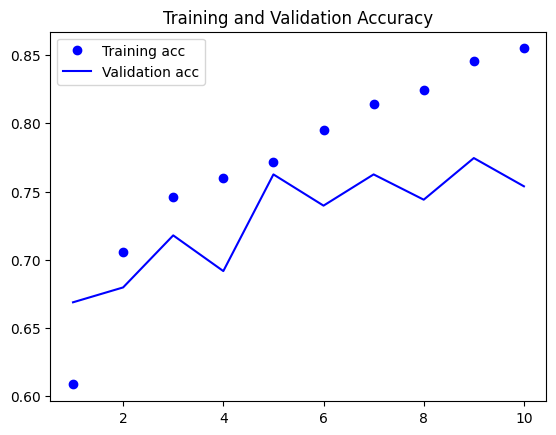

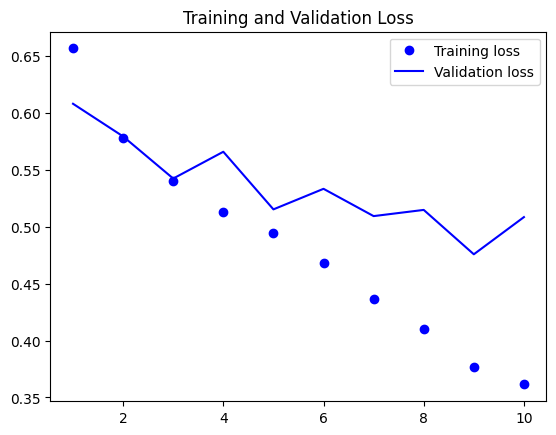

In [12]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [13]:
acc_median = np.median(acc)
acc_median

0.7833831906318665

**Answer**: 0.80

### Question 4

What is the standard deviation of training loss for all the epochs for this model?

* 0.031
* 0.061
* 0.091
* 0.131

In [14]:
loss_std = np.std(loss)
loss_std

0.0879349127586996

**Answer**: 0.088

### Data Augmentation

For the next two questions, we'll generate more data using data augmentations. 

Add the following augmentations to your training data generator:

* `rotation_range=50,`
* `width_shift_range=0.1,`
* `height_shift_range=0.1,`
* `zoom_range=0.1,`
* `horizontal_flip=True,`
* `fill_mode='nearest'`

In [15]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

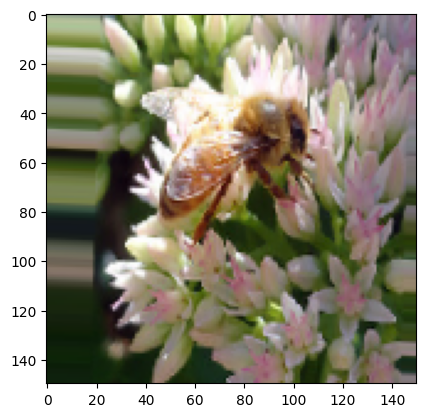

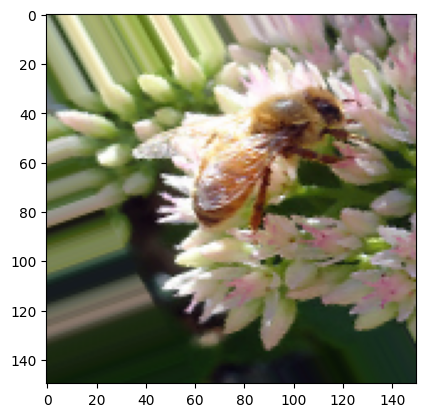

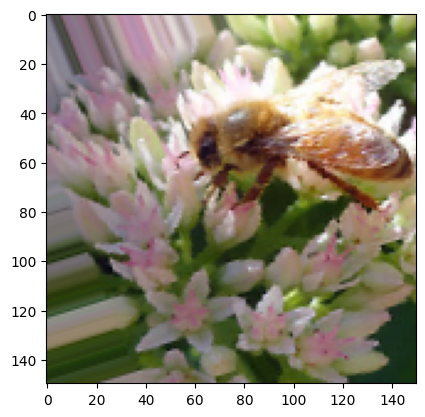

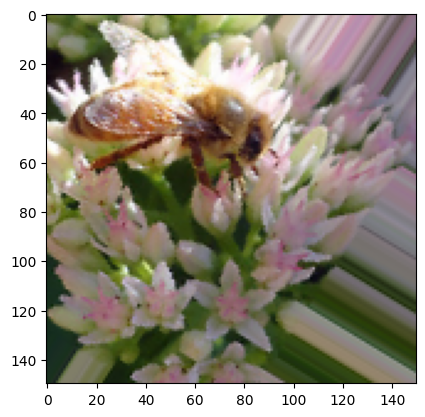

In [18]:
fnames = [os.path.join(train_dir+"/bee", fname) for
    fname in os.listdir(train_dir+"/bee")]

img_path = fnames[0]

img = image.load_img(img_path, target_size=(150, 150))

x = image.img_to_array(img)

x = x.reshape((1,) + x.shape)

i=0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break
plt.show()

### Question 5 

Let's train our model for 10 more epochs using the same code as previously.
> **Note:** make sure you don't re-create the model - we want to continue training the model
we already started training.

What is the mean of test loss for all the epochs for the model trained with augmentations?

* 0.18
* 0.48
* 0.78
* 0.108

In [19]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

In [20]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [21]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150, 150), 
                                                    batch_size=32, 
                                                    class_mode='binary')

Found 3677 images belonging to 2 classes.


In [23]:
validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

Found 918 images belonging to 2 classes.


In [24]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator)

Epoch 1/10
115/115 [==============================] - 20s 172ms/step - loss: 0.5111 - acc: 0.7539 - val_loss: 0.5169 - val_acc: 0.7505
Epoch 2/10
115/115 [==============================] - 20s 172ms/step - loss: 0.5260 - acc: 0.7411 - val_loss: 0.4886 - val_acc: 0.7821
Epoch 3/10
115/115 [==============================] - 20s 172ms/step - loss: 0.4912 - acc: 0.7637 - val_loss: 0.4869 - val_acc: 0.7767
Epoch 4/10
115/115 [==============================] - 20s 172ms/step - loss: 0.4860 - acc: 0.7808 - val_loss: 0.4646 - val_acc: 0.7887
Epoch 5/10
115/115 [==============================] - 20s 172ms/step - loss: 0.4758 - acc: 0.7808 - val_loss: 0.4645 - val_acc: 0.7832
Epoch 6/10
115/115 [==============================] - 22s 190ms/step - loss: 0.4851 - acc: 0.7729 - val_loss: 0.4671 - val_acc: 0.7843
Epoch 7/10
115/115 [==============================] - 20s 172ms/step - loss: 0.4698 - acc: 0.7849 - val_loss: 0.4556 - val_acc: 0.7996
Epoch 8/10
115/115 [==============================] - 2

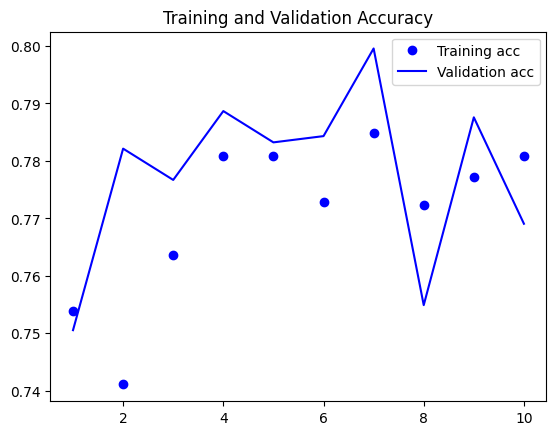

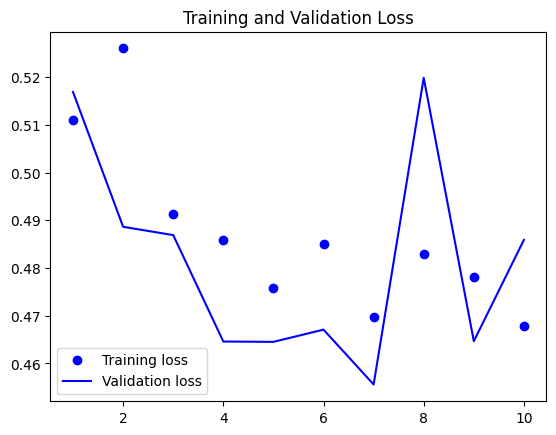

In [25]:
acc_aug = history.history['acc']
val_acc_aug = history.history['val_acc']
loss_aug = history.history['loss']
val_loss_aug = history.history['val_loss']

epochs_aug = range(1, len(acc) + 1)

plt.plot(epochs_aug, acc_aug, 'bo', label='Training acc')
plt.plot(epochs_aug, val_acc_aug, 'b', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_aug, loss_aug, 'bo', label='Training loss')
plt.plot(epochs_aug, val_loss_aug, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [26]:
loss_mean_aug = np.mean(val_loss_aug)
loss_mean_aug

0.4814674586057663

**Answer**: 0.48

### Question 6

What's the average of test accuracy for the last 5 epochs (from 6 to 10)
for the model trained with augmentations?

* 0.38
* 0.58
* 0.78
* 0.98

In [27]:
val_acc_aug[5:10]

[0.7843137383460999,
 0.7995642423629761,
 0.7549019455909729,
 0.7875816822052002,
 0.7690631747245789]

In [28]:
acc_mean_aug = np.mean(val_acc_aug[5:10])
acc_mean_aug

0.7790849566459656

**Answer**: 0.78